In [2]:
from pathlib import Path
import pickle
import sys

from cmocean import cm
from matplotlib import cm, colors
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import pandas as pd
import torch

sys.path.insert(0, str(Path.cwd() / "Source"))
from BOGP import utils
from BOGP.optimization import plotting
from BOGP.optimization.optimizer import Optimizer, BayesianOptimizationGPConfig, BOGPResults, RandomResults
from tritonoa.io import read_ssp

ROOT = Path.home() / "Research" / "Projects" / "BOGP"
DATAPATH = ROOT / "Data" / "Simulations"
FIGUREPATH = ROOT / "Reports" / "Figures"

# Simulations Dashboard

## Load data

In [ ]:
evaluations = {
    "acq_func": ["ProbabilityOfImprovement", "ExpectedImprovement", "qExpectedImprovement", "random"],
    "acq_func_abbrev": ["PI", "EI", "qEI", "Rand"],
    "snr": ["inf", "10"],
    "rec_r": ["0.5", "3.0", "6.0", "10.0"]
}
# folders = utils.folders_of_evaluations(evaluations)
EXPERIMENT1 = DATAPATH / "bogp" / "range_estimation"
df1 = pd.read_csv(EXPERIMENT1 / "aggregated.csv", index_col=0)
df1["best_param"] = df1["best_param"].str.strip("[").str.strip("]").astype(float)
df1 = df1[df1["snr"] == 10]

EXPERIMENT2 = DATAPATH / "random" / "range_estimation"
df2 = pd.read_csv(EXPERIMENT2 / "aggregated.csv", index_col=0)
df2["best_param"] = df2["best_param"].str.strip("[").str.strip("]").astype(float)
df2 = df2[df2["snr"] == 10]

dfr = pd.concat([df1, df2])
del df1, df2

evaluations = {
    "acq_func": ["ProbabilityOfImprovement", "ExpectedImprovement", "qExpectedImprovement", "random"],
    "acq_func_abbrev": ["PI", "EI", "qEI", "Rand"],
    "snr": ["inf", "10"],
    "rec_r": ["0.5", "3.0", "6.0", "10.0"],
    "src_z": ["62"]
}

EXPERIMENT1 = DATAPATH / "bogp" / "localization"
df1 = pd.read_csv(EXPERIMENT1 / "aggregated.csv", index_col=0)
new_cols = df1["best_param"].str.strip("[ ").str.strip(" ]").str.split(" ", n=1, expand=True)
new_cols.columns = [f"best_param{col}" for col in new_cols.columns]
df1 = pd.concat([df1, new_cols], axis=1).drop("best_param", axis=1)
df1 = df1[df1["snr"] == 10]

EXPERIMENT2 = DATAPATH / "random" / "localization"
df2 = pd.read_csv(EXPERIMENT2 / "aggregated.csv", index_col=0)
new_cols = df2["best_param"].str.strip("[ ").str.strip(" ]").str.split(" ", n=1, expand=True)
new_cols.columns = [f"best_param{col}" for col in new_cols.columns]
df2 = pd.concat([df2, new_cols], axis=1).drop("best_param", axis=1)
df2 = df2[df2["snr"] == 10]

dfl = pd.concat([df1, df2])
del df1, df2

## Dashboard Function

In [ ]:
def simulations_dashboard(dfr, dfl):
    plot_flag = True

    LEGENDSIZE = 12

    AMBSURFKWARGS = {"color": colors.CSS4_COLORS["fuchsia"], "markersize": 25}

    CBAR_KWARGS = {"label": "Normalized Correlation [dB]", "size": LEGENDSIZE}

    LETTERS_KW = {
        "fontsize": "xx-large",
        "fontfamily": "serif",
    }

    LEGEND_KW = {
        "ncol": 5,
        "loc": "center",
        "bbox_to_anchor": (0.5, -0.75),
        "prop": {"size": LEGENDSIZE},
    }

    MFP_KW = {"color": colors.CSS4_COLORS["fuchsia"], "label": "MFP"}

    TITLE_KW = {"ha": "left", "va": "top", "x": 0, "y": 1.4}

    fig, axs = plt.subplots(
        nrows=4,
        ncols=6,
        figsize=(18, 6),
        facecolor="white",
        dpi=200,
        gridspec_kw={"width_ratios": [2, 1, 1, 1, 1, 1], "wspace": 0.2},
    )
    # ranges = df["rec_r"].unique()

    # Subplot letters
    letters = "abcdef"
    [
        axs[0, i].text(
            -0.25, 1.3, f"({letters[i]})", transform=axs[0, i].transAxes, **LETTERS_KW
        )
        for i in range(len(letters))
    ]

    simulations = {
        "acq_func": [
            "ProbabilityOfImprovement",
            "ExpectedImprovement",
            "qExpectedImprovement",
            "random",
        ],
        "acq_func_abbrev": ["PI", "EI", "qEI", "Rand"],
        "snr": ["inf", "10"],
        "rec_r": ["0.5", "3.0", "6.0", "10.0"],
        "src_z": ["62"],
    }
    ranges = [float(i) for i in simulations["rec_r"]]

    XLIM_R = [-5, 205]
    XLIM_L = [-5, 1005]
    YLIM_PERF = [0, 1.05]
    YLIM_RERR = [-0.5, 10]
    YLIM_ZERR = [-5, 100]

    # ================================================================ #
    # ======================= Ambiguity Surfaces ===================== #
    # ================================================================ #

    axcol = axs[:, 0]

    XLIM = [0, 10]
    YLIM = [200, 0]
    XLABEL = "Range [km]"
    YLABEL = "Depth [m]"

    # Set ranges
    [
        axcol[i].text(
            -0.6,
            0.5,
            f"$r_\mathrm{{src}} = {r}$ km",
            transform=axcol[i].transAxes,
            fontsize="x-large",
        )
        for i, r in enumerate(ranges)
    ]

    # Set title
    axcol[0].set_title("Ambiguity Surface\n$f(\mathbf{x})$", **TITLE_KW)

    # Set x axis
    [axcol[i].set_xlim(XLIM) for i in range(len(ranges))]
    [axcol[i].set_xticklabels([]) for i in range(len(ranges) - 1)]
    [axcol[-1].set_xlabel(XLABEL)]

    # Set y axis
    [axcol[i].set_ylim(YLIM) for i, _ in enumerate(ranges)]
    axcol[-1].set_ylabel(YLABEL)

    if plot_flag:
        for i, r in enumerate(ranges):
            data = np.load(
                ROOT
                / "Data"
                / "SWELLEX96"
                / "ambiguity_surfaces"
                / f"201Hz_62m_{r}km.npz"
            )
            B = data["B"]
            rvec = data["rvec"]
            zvec = data["zvec"]
            ax, im = plotting.plot_ambiguity_surface(
                B, rvec, zvec, ax=axcol[i], **AMBSURFKWARGS
            )
    else:
        ax = axcol[-1]

    cax = inset_axes(
        ax,
        width="100%",
        height="10%",
        loc="center",
        bbox_to_anchor=(0, -1.1, 1, 1),
        bbox_transform=ax.transAxes,
    )

    if plot_flag:
        cbar = fig.colorbar(im, cax=cax, orientation="horizontal").set_label(
            **CBAR_KWARGS
        )

    # ================================================================ #
    # ======================== Range Estimation ====================== #
    # ================================================================ #
    # Get values from pre-computed MFP results
    mfp_max = []
    mfp_r = []
    for i, r in enumerate(ranges):
        data = np.load(
            ROOT
            / "Data"
            / "Simulations"
            / "working"
            / "mfp"
            / f"range_201Hz_62m_{r}km.npz"
        )
        B = data["B"]
        rvec = data["rvec"]
        src_r_ind = np.argmax(B)
        mfp_max.append(B.max())
        mfp_r.append(np.abs(rvec[src_r_ind] - r))

    XLABEL = "Evaluation"
    # ======================= Performance History ==================== #
    axcol = axs[:, 1]
    VALUE_TO_PLOT = "best_value"
    YLABEL = "$\hat{f}(\mathbf{x})$"
    OPTIMUM = 1.0
    LOWER_THRESHOLD = 0
    UPPER_THRESHOLD = 1

    # Set title
    axcol[0].set_title(f"Range Estimation:\n{YLABEL}", **TITLE_KW)

    # Set x axis
    [axcol[i].set_xlim(XLIM_R) for i in range(len(ranges))]
    [axcol[i].set_xticklabels([]) for i in range(len(ranges) - 1)]
    [axcol[-1].set_xlabel(XLABEL)]

    # Set y axis
    [axcol[i].set_ylim(YLIM_PERF) for i in range(len(ranges))]
    # axcol[-1].set_ylabel(YLABEL)

    # Draw plots
    if plot_flag:
        lines = [
                plotting.plot_agg_data(
                    dfr[dfr["rec_r"] == r],
                    simulations,
                    VALUE_TO_PLOT,
                    optimum=OPTIMUM,
                    lower_threshold=LOWER_THRESHOLD,
                    upper_threshold=UPPER_THRESHOLD,
                    ax=axcol[i],
                    additional_values=[{"y": mfp_max[i]+1} | MFP_KW]
                )
            
            for i, r in enumerate(ranges)
        ]

    # [axcol[i].axhline(mfp_max[i], **MFP_KW) for i in range(len(ranges))]

    # ====================== Range Error History ===================== #
    axcol = axs[:, 2]
    VALUE_TO_PLOT = "best_param"
    
    YLABEL = "$\\vert\hat{R}_{src} - R_{src}\\vert$"
    COMPUTE_ERROR_WITH = simulations["rec_r"]

    # Set title
    axcol[0].set_title(f"Range Estimation:\n{YLABEL} [km]", **TITLE_KW)

    # Set x axis
    [axcol[i].set_xlim(XLIM_R) for i in range(len(ranges))]
    [axcol[i].set_xticklabels([]) for i in range(len(ranges) - 1)]
    [axcol[-1].set_xlabel(XLABEL)]

    # Set y axis
    [axcol[i].set_ylim(YLIM_RERR) for i in range(len(ranges))]
    # axcol[-1].set_ylabel(YLABEL)

    # Draw plots
    if plot_flag:
        lines = [
            plotting.plot_agg_data(
                dfr[dfr["rec_r"] == r],
                simulations,
                VALUE_TO_PLOT,
                lower_threshold=LOWER_THRESHOLD,
                compute_error_with=float(COMPUTE_ERROR_WITH[i]),
                ax=axcol[i],
                additional_values=[{"y": mfp_r[i]} | MFP_KW]
            )
            for i, r in enumerate(ranges)
        ]

    # ================================================================ #
    # ========================== Localization ======================== #
    # ================================================================ #
    # Get values from pre-computed MFP results
    mfp_max = []
    mfp_r = []
    mfp_z = []

    for i, r in enumerate(ranges):
        data = np.load(
            ROOT
            / "Data"
            / "Simulations"
            / "working"
            / "mfp"
            / f"local_201Hz_62m_{r}km.npz"
        )
        B = data["B"]
        rvec = data["rvec"]
        zvec = data["zvec"]
        src_z_ind, src_r_ind = np.unravel_index(np.argmax(B), (len(zvec), len(rvec)))

        mfp_max.append(B.max())
        # mfp_z.append(zvec[src_z_ind])
        mfp_z.append(np.abs(zvec[src_z_ind] - float(evaluations["src_z"][0])))
        mfp_r.append(np.abs(rvec[src_r_ind] - r))

    # ======================= Performance History ==================== #
    axcol = axs[:, 3]
    VALUE_TO_PLOT = "best_value"
    YLABEL = "$\hat{f}(\mathbf{x})$"
    OPTIMUM = 1.0
    LOWER_THRESHOLD = 0
    UPPER_THRESHOLD = 1

    axcol[0].set_title(f"Localization:\n{YLABEL}", **TITLE_KW)

    # Set x axis
    [axcol[i].set_xlim(XLIM_L) for i in range(len(ranges))]
    [axcol[i].set_xticklabels([]) for i in range(len(ranges) - 1)]
    [axcol[-1].set_xlabel(XLABEL)]

    # Set y axis
    [axcol[i].set_ylim(YLIM_PERF) for i in range(len(ranges))]
    # axcol[-1].set_ylabel(YLABEL)

    # Draw plots
    if plot_flag:
        lines = [
            plotting.plot_agg_data(
                dfl[dfl["rec_r"] == r],
                simulations,
                VALUE_TO_PLOT,
                optimum=OPTIMUM,
                lower_threshold=LOWER_THRESHOLD,
                upper_threshold=UPPER_THRESHOLD,
                ax=axcol[i],
                additional_values=[{"y": mfp_max[i]+1} | MFP_KW],
            )
            for i, r in enumerate(ranges)
        ]
    else:
        lines = [
            plotting.plot_agg_data(
                dfl[dfl["rec_r"] == ranges[0]],
                simulations,
                VALUE_TO_PLOT,
                optimum=OPTIMUM,
                lower_threshold=LOWER_THRESHOLD,
                upper_threshold=UPPER_THRESHOLD,
                ax=axcol[0],
                additional_values=[{"y": mfp_max[0]+1} | MFP_KW],
            )
        ]

    axcol[-1].legend(handles=lines[-1], **LEGEND_KW)

    # ====================== Range Error History ===================== #
    axcol = axs[:, 4]
    VALUE_TO_PLOT = "best_param0"
    YLIM = [-0.2, 10]
    YLABEL = "$\\vert\hat{R}_{src} - R_{src}\\vert$"
    COMPUTE_ERROR_WITH = simulations["rec_r"]

    # Set title
    axcol[0].set_title(f"Localization:\n{YLABEL} [km]", **TITLE_KW)

    # Set x axis
    [axcol[i].set_xlim(XLIM_L) for i in range(len(ranges))]
    [axcol[i].set_xticklabels([]) for i in range(len(ranges) - 1)]
    [axcol[-1].set_xlabel(XLABEL)]

    # Set y axis
    [axcol[i].set_ylim(YLIM_RERR) for i in range(len(ranges))]
    # axcol[-1].set_ylabel(YLABEL)

    # Draw plots
    if plot_flag:
        lines = [
            plotting.plot_agg_data(
                dfl[dfl["rec_r"] == r],
                simulations,
                VALUE_TO_PLOT,
                lower_threshold=LOWER_THRESHOLD,
                compute_error_with=float(COMPUTE_ERROR_WITH[i]),
                ax=axcol[i],
                additional_values=[{"y": mfp_r[i]} | MFP_KW]
            )
            for i, r in enumerate(ranges)
        ]

    # ====================== Depth Error History ===================== #
    axcol = axs[:, 5]
    VALUE_TO_PLOT = "best_param1"
    
    YLABEL = "$\\vert\hat{z}_{src} - z_{src}\\vert$"
    COMPUTE_ERROR_WITH = [simulations["src_z"][0] for i in range(len(ranges))]

    # Set title
    axcol[0].set_title(f"Localization:\n{YLABEL} [m]", **TITLE_KW)

    # Set x axis
    [axcol[i].set_xlim(XLIM_L) for i in range(len(ranges))]
    [axcol[i].set_xticklabels([]) for i in range(len(ranges) - 1)]
    [axcol[-1].set_xlabel(XLABEL)]

    # Set y axis
    [axcol[i].set_ylim(YLIM_ZERR) for i in range(len(ranges))]
    # axcol[-1].set_ylabel(YLABEL)

    # Draw plots
    if plot_flag:
        lines = [
            plotting.plot_agg_data(
                dfl[dfl["rec_r"] == r],
                simulations,
                VALUE_TO_PLOT,
                lower_threshold=LOWER_THRESHOLD,
                compute_error_with=float(COMPUTE_ERROR_WITH[i]),
                ax=axcol[i],
                additional_values=[{"y": mfp_z[i]} | MFP_KW]
            )
            for i, r in enumerate(ranges)
        ]


simulations_dashboard(dfr, dfl)

## Ambiguity surface plot

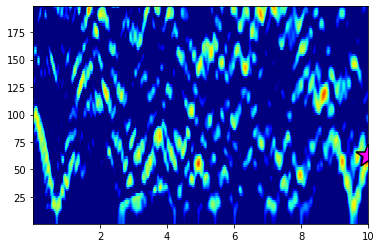

In [3]:
r = 10.0
data = np.load(
    ROOT
    / "Data"
    / "SWELLEX96"
    / "ambiguity_surfaces"
    / f"201Hz_62m_{r}km.npz"
)
B = data["B"]
rvec = data["rvec"]
zvec = data["zvec"]
AMBSURFKWARGS = {
    "color": colors.CSS4_COLORS["fuchsia"],
    # "cmap": cm.rain_r,
    "markersize": 25,
    "markeredgecolor": "k"
}
ax, im = plotting.plot_ambiguity_surface(B, rvec, zvec, **AMBSURFKWARGS)
plt.show()
# AMBSURFKWARGS = {
#     "cmap": cm.thermal_r,
#     "color": "w"
# }
# ax, im = plotting.plot_ambiguity_surface(B, rvec, zvec, **AMBSURFKWARGS)
# plt.show()

#### MFP range estimation on limited evaluation budget

In [4]:
ranges = [0.5, 3.0, 5.0, 7.0]

mfp_max = []
mfp_r = []

for i, r in enumerate(ranges):
    data = np.load(
        ROOT
        / "Data"
        / "Simulations"
        / "working"
        / "mfp"
        / f"range_201Hz_62m_{r}km.npz"
    )
    B = data["B"]
    rvec = data["rvec"]
    src_r_ind = np.argmax(B)

    mfp_max.append(B.max())
    mfp_r.append(rvec[src_r_ind])

    # plt.plot(rvec, B.squeeze())
    # ax = plt.gca()
    # line = ax.axvline(r, c="r")
    # plt.show()

print(mfp_max, mfp_r)

[1.0, 1.0, 1.0, 1.0] [0.503462311557789, 3.015773869346734, 5.02562311557789, 6.985226130653268]


#### MFP localization on limited evaluation budget

In [5]:
# ranges = [1.0, 3.0, 5.0, 7.0]
ranges = [0.5, 3.0, 6.0, 10.0]

mfp_max = []
mfp_r = []
mfp_z = []

for i, r in enumerate(ranges):
    data = np.load(
        ROOT
        / "Data"
        / "Simulations"
        / "working"
        / "mfp"
        / f"local_201Hz_62m_{r}km.npz"
    )
    B = data["B"]
    rvec = data["rvec"]
    zvec = data["zvec"]
    src_z_ind, src_r_ind = np.unravel_index(np.argmax(B), (len(zvec), len(rvec)))

    mfp_max.append(B.max())
    mfp_z.append(zvec[src_z_ind])
    mfp_r.append(rvec[src_r_ind])

    # plotting.plot_ambiguity_surface(B, rvec, zvec)
    # plt.plot(r, 62, "y*", markeredgecolor="k", markersize=25)
    # plt.gca().invert_yaxis()
    # plt.show()

print(mfp_max, mfp_z, mfp_r)

[1.0, 1.0, 1.0, 1.0] [84.5, 63.5, 11.0, 63.5] [0.4091224489795919, 3.061918367346939, 8.367510204081633, 10.0]
